## Introduction

This notebook is dedicated to create a loan grade classification model. I will be using lightgbm classification model to predict the loan grade.

## Importing necessary libraries

In [52]:
from lightgbm import LGBMClassifier

import functions as f
import pandas as pd
pd.set_option("display.max_columns", None)

from functions import CustomOrdinalEncoder, CustomWordExtractor, CustomCategoricalConverter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report

import shap
shap.initjs()

import pickle

## Importing Train and Test sets from EDA Notebook

In [53]:
train_set = pd.read_csv(
    "/Users/laurynas/Documents/DataScience/Projects/Data/lending-club/train_set_df_2.csv",
    low_memory=False,
)
test_set = pd.read_csv(
    "/Users/laurynas/Documents/DataScience/Projects/Data/lending-club/test_set_df_2.csv",
    low_memory=False,
)

In [54]:
X_train = train_set.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d", "earliest_cr_line"], axis=1
)
y_train = train_set["grade"]

## Building the Pipeline

In [55]:
emp_length_order = [
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
verification_status_order = [
    "Not Verified",
    "Verified",
    "Source Verified",
]
cat_features = [
    "home_ownership",
    "zip_code",
    "state",
    "initial_list_status",
    "application_type",
    "hardship_flag",
]
custom_word_pipeline = Pipeline(
    steps=[
        ("word_extractor", CustomWordExtractor(column_name=["emp_title", "purpose"])),
        (
            "ordinal_encoder",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
        ),
    ]
)
preprocess_pipeline = ColumnTransformer(
    transformers=[
        (
            "employment_length_encoder",
            CustomOrdinalEncoder(
                column_name="employment_length", order=emp_length_order
            ),
            ["employment_length"],
        ),
        (
            "verification_status_encoder",
            CustomOrdinalEncoder(
                column_name="verification_status", order=verification_status_order
            ),
            ["verification_status"],
        ),
        ("custom_word_pipeline", custom_word_pipeline, ["emp_title", "purpose"]),
        (
            "cat_encoding",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
            cat_features,
        ),
    ],
    remainder="passthrough",
)
preprocess_pipeline.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('employment_length_encoder',
                                 CustomOrdinalEncoder(column_name='employment_length',
                                                      order=['< 1 year',
                                                             '1 year',
                                                             '2 years',
                                                             '3 years',
                                                             '4 years',
                                                             '5 years',
                                                             '6 years',
                                                             '7 years',
                                                             '8 years',
                                                             '9 years',
                                                             '10+ years']),
                                 ['employment_length']),
                                ('verification_status_encoder',
                                 CustomOrdinalEncoder(column_name='verification_st...
                                                  CustomWordExtractor(column_name=['emp_title',
                                                                                   'purpose'])),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(encoding_method='arbitrary',
                                                                 missing_values='ignore',
                                                                 unseen='encode'))]),
                                 ['emp_title', 'purpose']),
                                ('cat_encoding',
                                 OrdinalEncoder(encoding_method='arbitrary',
                                                missing_values='ignore',
                                                unseen='encode'),
                                 ['home_ownership', 'zip_code', 'state',
                                  'initial_list_status', 'application_type',
                                  'hardship_flag'])])

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42
)

In [57]:
cat_features = [
    "employment_length_encoder__employment_length",
    "verification_status_encoder__verification_status",
    "custom_word_pipeline__emp_title",
    "custom_word_pipeline__purpose",
    "cat_encoding__home_ownership",
    "cat_encoding__zip_code",
    "cat_encoding__state",
    "cat_encoding__initial_list_status",
    "cat_encoding__application_type",
    "cat_encoding__hardship_flag",
]
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_features),
        ),
    ]
)
X_train_transform = pipeline.fit_transform(X_train)
X_valid_transform = pipeline.transform(X_valid)

In [58]:
classifier = LGBMClassifier(random_state=1, n_jobs=-1, objective="multiclass")
classifier.fit(
    X_train_transform,
    y_train,
    early_stopping_rounds=15,
    eval_set=[(X_valid_transform, y_valid)],
    categorical_feature=cat_features,
    verbose=-1,
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_encoding__application_type', 'cat_encoding__hardship_flag', 'cat_encoding__home_ownership', 'cat_encoding__initial_list_status', 'cat_encoding__state', 'cat_encoding__zip_code', 'custom_word_pipeline__emp_title', 'custom_word_pipeline__purpose', 'employment_length_encoder__employment_length', 'verification_status_encoder__verification_status']
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMClassifier(objective='multiclass', random_state=1)

MODEL EVALUATION ON TRAINING SET
              precision    recall  f1-score   support

           A       0.90      0.88      0.89    277293
           B       0.81      0.84      0.82    424202
           C       0.80      0.85      0.82    416127
           D       0.77      0.72      0.74    207734
           E       0.74      0.61      0.67     86854
           F       0.72      0.56      0.63     26734
           G       0.63      0.50      0.56      7881

    accuracy                           0.81   1446825
   macro avg       0.77      0.71      0.73   1446825
weighted avg       0.81      0.81      0.81   1446825



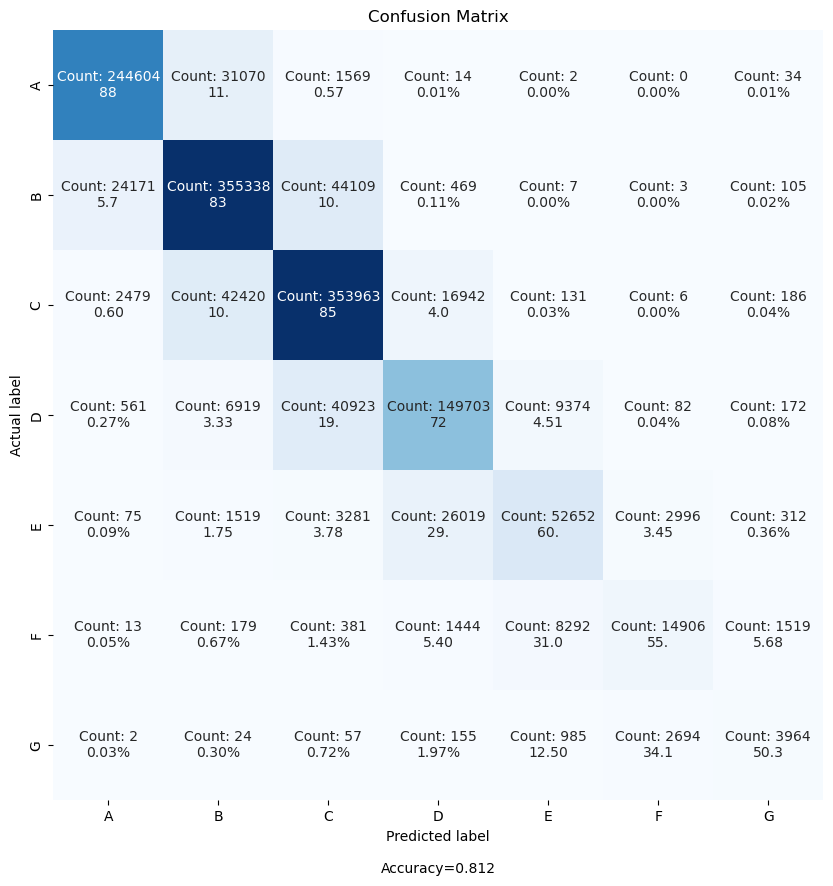

In [59]:
print("MODEL EVALUATION ON TRAINING SET")
y_pred = classifier.predict(X_train_transform)
print(classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
f.plot_confusion_matrix(
    cm, figsize=(10, 10), categories=["A", "B", "C", "D", "E", "F", "G"]
)

MODEL EVALUATION ON VALIDATION SET
              precision    recall  f1-score   support

           A       0.90      0.88      0.89     69187
           B       0.81      0.83      0.82    106321
           C       0.79      0.84      0.82    103944
           D       0.76      0.71      0.73     51811
           E       0.71      0.58      0.64     21857
           F       0.62      0.47      0.53      6698
           G       0.38      0.34      0.36      1889

    accuracy                           0.80    361707
   macro avg       0.71      0.66      0.68    361707
weighted avg       0.80      0.80      0.80    361707



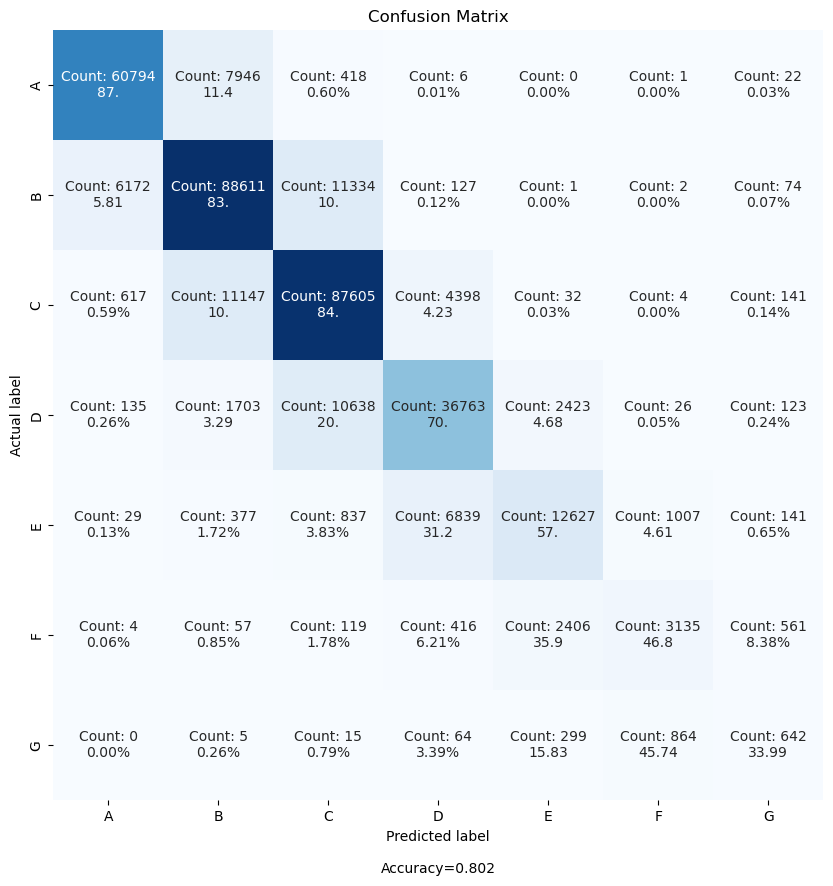

In [60]:
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = classifier.predict(X_valid_transform)
print(classification_report(y_valid, y_pred))
cm = confusion_matrix(y_valid, y_pred)
f.plot_confusion_matrix(
    cm, figsize=(10, 10), categories=["A", "B", "C", "D", "E", "F", "G"]
)

<Axes: >

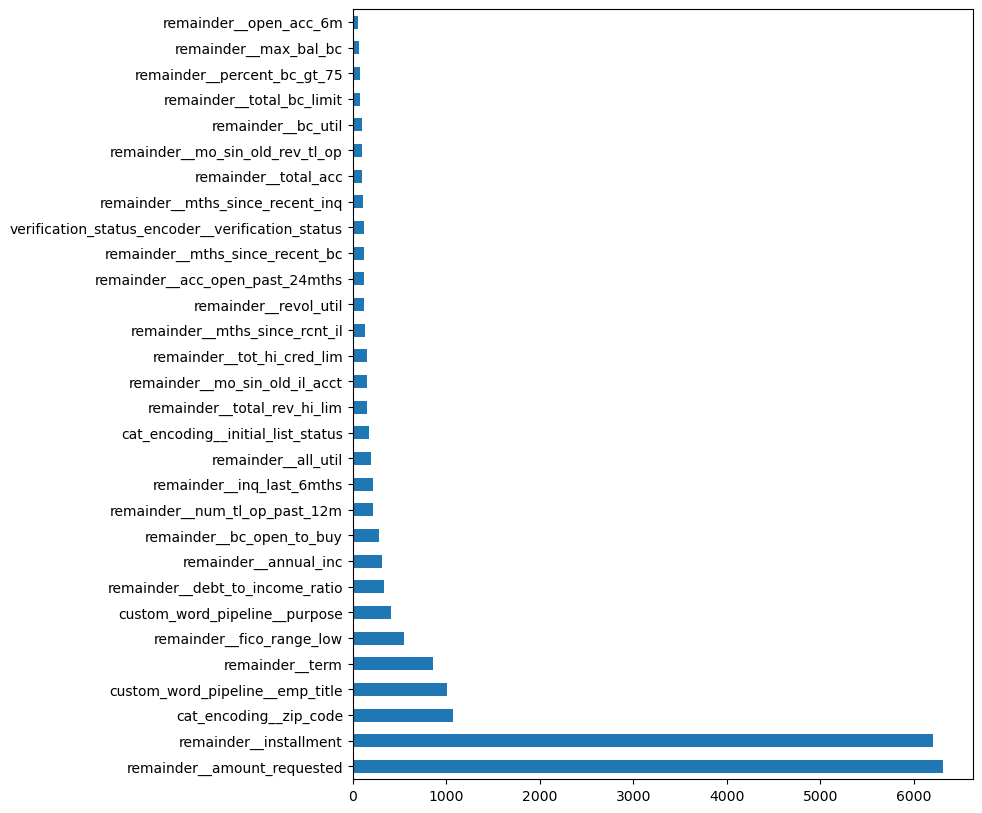

In [61]:
feat_imp = pd.Series(classifier.feature_importances_, index=X_train_transform.columns)
feat_imp.nlargest(30).plot(kind="barh", figsize=(8, 10))

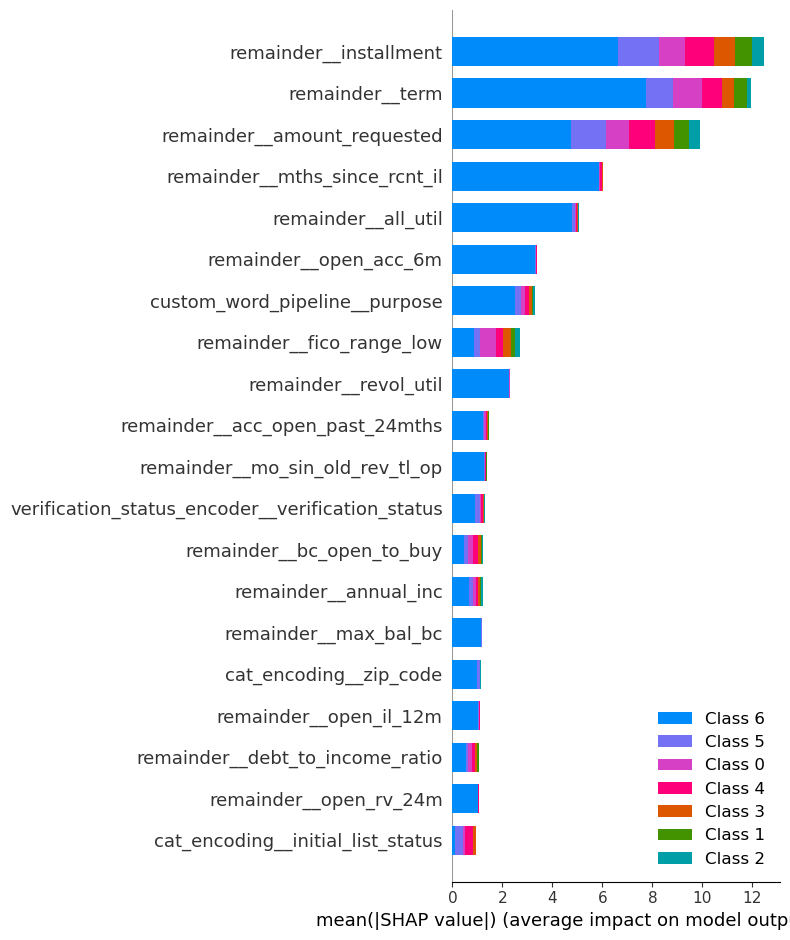

In [18]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train_transform)
shap.summary_plot(shap_values, X_train_transform)

In [63]:
selected_features = [
    "remainder__installment",
    "remainder__term",
    "remainder__amount_requested",
    "remainder__mths_since_rcnt_il",
    "remainder__all_util",
    "remainder__open_acc_6m",
    "custom_word_pipeline__purpose",
    "remainder__fico_range_low",
    "custom_word_pipeline__emp_title",
]
features_to_drop = list(set(X_train_transform.columns) - set(selected_features))
final_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_features),
        ),
        ("drop_features", DropFeatures(features_to_drop)),
    ]
)
X_train_transform = final_pipeline.fit_transform(X_train)
X_valid_transform = final_pipeline.transform(X_valid)

In [64]:
clf = LGBMClassifier(random_state=1, n_jobs=-1, objective="multiclass", early_stopping_rounds = 15)
clf.fit(X_train_transform, y_train, eval_set=[(X_valid_transform, y_valid)], verbose=-1)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] early_stopping_round is set=15, early_stopping_rounds=15 will be ignored. Current value: early_stopping_round=15


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMClassifier(early_stopping_rounds=15, objective='multiclass', random_state=1)

MODEL EVALUATION ON TRAINING SET
              precision    recall  f1-score   support

           A       0.91      0.92      0.91    277293
           B       0.85      0.85      0.85    424202
           C       0.82      0.87      0.84    416127
           D       0.79      0.76      0.78    207734
           E       0.76      0.65      0.70     86854
           F       0.74      0.59      0.66     26734
           G       0.64      0.59      0.62      7881

    accuracy                           0.84   1446825
   macro avg       0.79      0.75      0.77   1446825
weighted avg       0.84      0.84      0.84   1446825



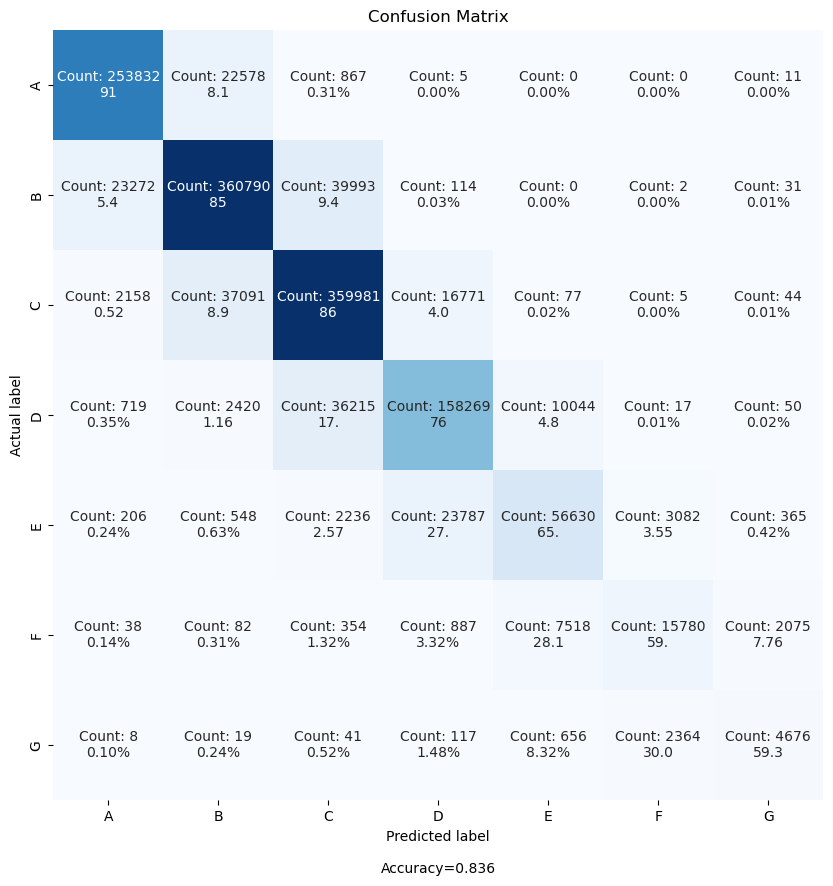

In [65]:
print("MODEL EVALUATION ON TRAINING SET")
y_pred = clf.predict(X_train_transform)
print(classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
f.plot_confusion_matrix(cm, figsize=(10,10), categories=["A", "B", "C", "D", "E", "F", "G"])

MODEL EVALUATION ON VALIDATION SET
              precision    recall  f1-score   support

           A       0.90      0.91      0.91     69187
           B       0.85      0.85      0.85    106321
           C       0.82      0.86      0.84    103944
           D       0.79      0.75      0.77     51811
           E       0.73      0.63      0.68     21857
           F       0.66      0.52      0.58      6698
           G       0.47      0.44      0.46      1889

    accuracy                           0.83    361707
   macro avg       0.75      0.71      0.73    361707
weighted avg       0.83      0.83      0.83    361707



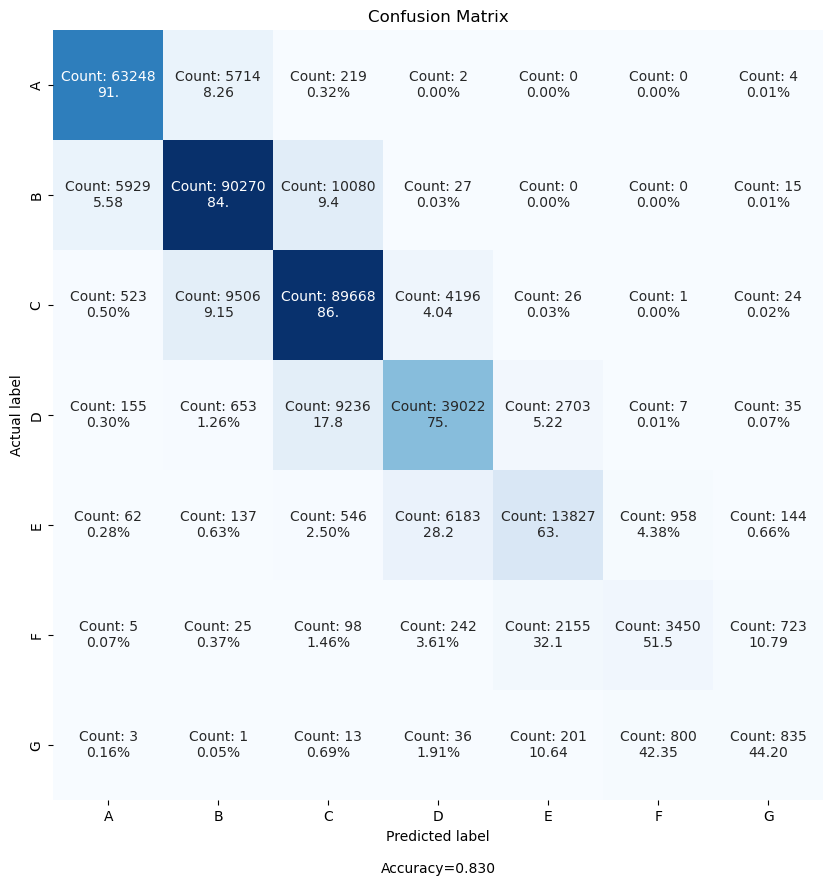

In [66]:
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = clf.predict(X_valid_transform)
print(classification_report(y_valid, y_pred))
cm = confusion_matrix(y_valid, y_pred)
f.plot_confusion_matrix(cm, figsize=(10,10), categories=["A", "B", "C", "D", "E", "F", "G"])

## Final Model Evaluation on Test Set

In [67]:
X_test = test_set.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d", "earliest_cr_line"], axis=1
)
y_test = test_set["grade"]
X_test_transform = final_pipeline.transform(X_test)

MODEL EVALUATION ON TEST SET
              precision    recall  f1-score   support

           A       0.90      0.91      0.91     86547
           B       0.85      0.85      0.85    133033
           C       0.82      0.86      0.84    129981
           D       0.79      0.75      0.77     64879
           E       0.73      0.64      0.68     26928
           F       0.68      0.53      0.60      8368
           G       0.48      0.42      0.45      2398

    accuracy                           0.83    452134
   macro avg       0.75      0.71      0.73    452134
weighted avg       0.83      0.83      0.83    452134



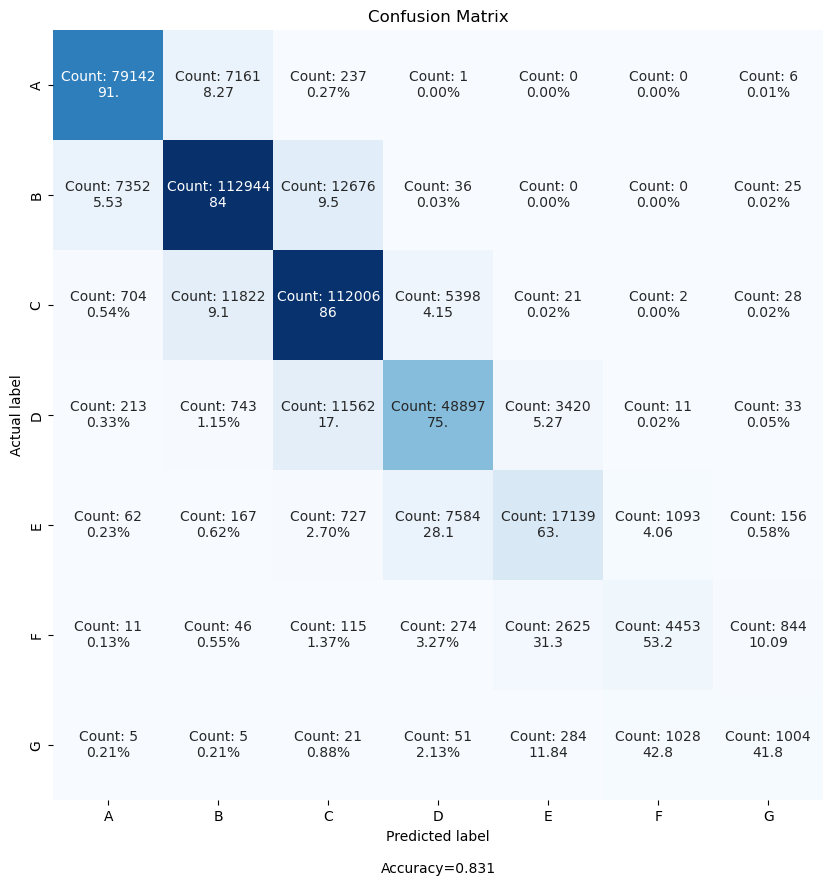

In [68]:
print("MODEL EVALUATION ON TEST SET")
y_pred = clf.predict(X_test_transform)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
f.plot_confusion_matrix(cm, figsize=(10,10), categories=["A", "B", "C", "D", "E", "F", "G"])

## Saving the model

In [69]:
# with open("grade_model-0.1.0.pkl", "wb") as f:
#     pickle.dump(clf, f)